<a href="https://colab.research.google.com/github/darelover/Neural-Style-Transfer/blob/master/Neural_Style_Transfer_using_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
cd ../gdrive/My Drive/NST

/gdrive/My Drive/NST


In [0]:
import os

# for reading and writing image
import imageio
# for loading vgg model
import scipy.io

import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np

%matplotlib inline

In [0]:
IMAGE_WIDTH = 800
IMAGE_HEIGHT = 600
COLOR_CHANNELS = 3

NOISE_RATIO = 0.6

MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 

ALPHA_ARRAY = [0.025, 1, 5, 10, 7.5, 10]
BETA_ARRAY = [5, 500, 100, 40, 100, 5000]
idx = 5 
ALPHA = ALPHA_ARRAY[idx]
BETA = BETA_ARRAY[idx]

ITERATION = 5000

CONTENT_DIR = "./Content/"
STYLE_DIR = "./Style/"

# CONTENT_IMAGE =  "ContentTaipei.jpg"
# CONTENT_IMAGE =  "ContentMacau.jpg"
# CONTENT_IMAGE =  "ContentLouvre.jpg"
CONTENT_IMAGE =  "ContentStarWars.jpg"

# STYLE_IMAGE = "StyleStarryNight.jpg"
# STYLE_IMAGE = "StyleMonet.jpg"
STYLE_IMAGE = "StyleFeneck.jpg"
# STYLE_IMAGE = "StyleCottonFabric.jpg"

OUTOUT_DIR = "./Output/"
OUTPUT_IMAGE = "Generated.png" 
OUTPUT_PLOT = "Plot.png"

CONTENT_LAYERS =[
    ('conv4_2',1.)
]

STYLE_LAYERS = [
    ('conv1_1', 0.5),
    ('conv2_1', 1.0),
    ('conv3_1', 1.5),
    ('conv4_1', 3.0),
    ('conv5_1', 4.0)
]

In [0]:
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """

        W          = vgg_layers[0][layer][0][0][2][0][0]
        b          = vgg_layers[0][layer][0][0][2][0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        
        assert layer_name == expected_layer_name
        
        return W, b

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)
      
    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']    = tf.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

In [6]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
model

Instructions for updating:
Colocations handled automatically by placer.


{'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 300, 400, 64) dtype=float32>,
 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 150, 200, 128) dtype=float32>,
 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 75, 100, 256) dtype=float32>,
 'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 38, 50, 512) dtype=float32>,
 'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 19, 25, 512) dtype=float32>,
 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 600, 800, 64) dtype=float32>,
 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 600, 800, 64) dtype=float32>,
 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 300, 400, 128) dtype=float32>,
 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 300, 400, 128) dtype=float32>,
 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 150, 200, 256) dtype=float32>,
 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 150, 200, 256) dtype=float32>,
 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 150, 200, 256) dtype=float32>,
 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 150, 200, 256) dtype=float32>,
 'conv4_1': <tf.T

In [0]:
def reshape_and_normalize_image(image):

    # Reshape image to mach expected input of VGG16
    image = np.reshape(image, ((1,) + image.shape))
    
    # Substract the mean to match the expected input of VGG16
    image = image - MEANS
    
    return image

In [0]:
def save_image(path, image):
    
    # Un-normalize the image so that it looks good
    image = image + MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    imageio.imsave(path, image)

(600, 800, 3)
(1, 600, 800, 3)


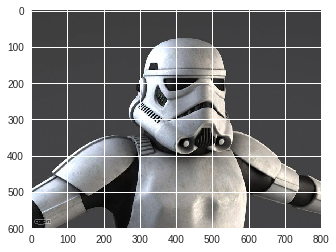

In [9]:
content_image = imageio.imread(CONTENT_DIR + CONTENT_IMAGE)

print content_image.shape

plt.imshow(content_image)

content_image = reshape_and_normalize_image(content_image)

print content_image.shape

(600, 800, 3)
(1, 600, 800, 3)


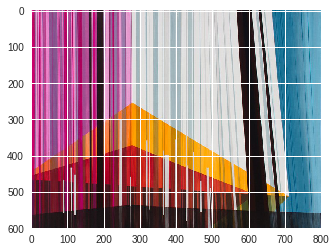

In [10]:
style_image = imageio.imread(STYLE_DIR + STYLE_IMAGE)

print style_image.shape

plt.imshow(style_image)

style_image = reshape_and_normalize_image(style_image)

print style_image.shape

In [0]:
def generate_noise_image(content_image):
  
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * NOISE_RATIO + content_image * (1 - NOISE_RATIO)
    
    return input_image


(1, 600, 800, 3)


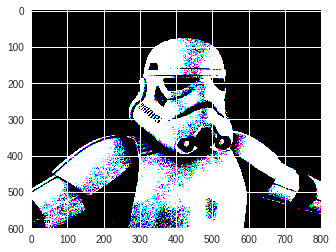

In [12]:
generated_image = generate_noise_image(content_image)
print generated_image.shape
plt.imshow(generated_image[0])

In [0]:
def compute_content_cost(a_C, a_G):
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
#     J_content = tf.reduce_sum(tf.square(tf.subtract(a_C,a_G)))/2
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C,a_G)))/(4*n_H*n_W*n_C)
#     J_content = tf.reduce_sum(tf.square(tf.subtract(a_C,a_G)))/(2* n_C**0.5 * (n_H*n_W)**0.5 )

    return J_content

def gram_matrix(A):
    GA = tf.matmul(A,tf.transpose(A))
    return GA

def compute_layer_style_cost(a_S, a_G):
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S,[n_H*n_W,n_C]))
    GS = gram_matrix(a_S)
    
    a_G = tf.transpose(tf.reshape(a_G,[n_H*n_W,n_C]))
    GG = gram_matrix(a_G)
    
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS,GG)))/((2*n_C*n_H*n_W)**2)
    
    return J_style_layer

In [14]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

J_content=0
sess.run([model['input'].assign(content_image)])
for layer, wt in CONTENT_LAYERS:
    J_content += wt * compute_content_cost(sess.run(model[layer]) ,  model[layer])

J_style=0
sess.run([model['input'].assign(style_image)])
for layer, wt in STYLE_LAYERS:
    J_style += wt * compute_layer_style_cost(sess.run(model[layer]) ,  model[layer])

J = ALPHA*J_content + BETA*J_style

optimizer = tf.train.AdamOptimizer(2.0)
train = optimizer.minimize(J)

if not os.path.exists(OUTOUT_DIR):
    os.mkdir(OUTOUT_DIR)
    
J_total_list = []
J_content_list = []
J_style_list = []
epoch = []

sess.run(tf.global_variables_initializer())

sess.run(model['input'].assign(generated_image))
for i in range(0,ITERATION+1):
    sess.run(train)
    
    if i%500==0:
        Jt, Jc, Js, generated_image = sess.run([J, J_content, J_style, model['input']])

        J_total_list.append(Jt)
        J_content_list.append(Jc)
        J_style_list.append(Js)
        epoch.append(i)

        print("Iteration " + str(i) + " :")
        print("total cost = " + str(Jt))
        print("content cost = " + str(Jc))
        print("style cost = " + str(Js))
        print("\n")

        save_image(OUTOUT_DIR + str(i) + ".png", generated_image)

save_image(OUTOUT_DIR + OUTPUT_IMAGE, generated_image)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Iteration 0 :
total cost = 114026350000000.0
content cost = 6207.201
style cost = 22805270000.0


Iteration 500 :
total cost = 416670000000.0
content cost = 30612.408
style cost = 83333940.0


Iteration 1000 :
total cost = 169900200000.0
content cost = 31264.805
style cost = 33979976.0


Iteration 1500 :
total cost = 95004566000.0
content cost = 31685.312
style cost = 19000850.0


Iteration 2000 :
total cost = 61256030000.0
content cost = 32003.27
style cost = 12251142.0


Iteration 2500 :
total cost = 43704600000.0
content cost = 32193.965
style cost = 8740855.0


Iteration 3000 :
total cost = 59653650000.0
content cost = 32997.84
style cost = 11930663.0


Iteration 3500 :
total cost = 34668503000.0
content cost = 32931.848
style cost = 6933635.0


Iteration 4000 :
total cost = 26501034000.0
content cost = 32921.79
style cost = 5300141.0


Iteration 4500 :
total cost = 45432910000.0
content cost = 33580.246
styl

In [0]:
# plt.plot(J_total_list,'r')
# plt.plot(J_content_list,'g')
# plt.plot(J_style_list,'b')
# plt.xlabel("Num of Epochs")
# plt.ylabel("Loss")
# plt.legend(['J_total','J_content', 'J_style'])
# plt.savefig(OUTOUT_DIR + OUTPUT_PLOT)